In [1]:
from datetime import datetime
import traceback
import functools
import multiprocessing
from multiprocessing import Pool

import time
import os
import sys
from pathlib import Path

import numpy as np
import scipy
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from astropy import stats

import astropy.units as u
from astropy.io import fits
from mmtwfs.wfs import WFSFactory

In [2]:
def get_traceback(f):
    @functools.wraps(f)
    def wrapper(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except Exception as ex:
            ret = '#' * 60
            ret += "\nException caught:"
            ret += "\n"+'-'*60
            ret += "\n" + traceback.format_exc()
            ret += "\n" + '-' * 60
            ret += "\n"+ "#" * 60
            print(sys.stderr, ret)
            sys.stderr.flush()
            raise ex
 
    return wrapper

In [3]:
# instantiate all of the WFS systems...
wfs_keys = ['newf9', 'f5', 'mmirs', 'binospec']
wfs_systems = {}
wfs_names = {}
for w in wfs_keys:
    wfs_systems[w] = WFSFactory(wfs=w)
    wfs_names[w] = wfs_systems[w].name
plt.close('all')

# it appears the binospec reference LED doesn't use a pinhole so the reference spots are smeared out. as a hack
# we'll assume the spots are nyquist sampled like the f5 and mmirs systems.
#wfs_systems['binospec'].modes['binospec']['reference']['fwhm'] = 2.0
#wfs_systems['binospec'].modes['binospec']['reference']['sigma'] = 2.0 * stats.funcs.gaussian_fwhm_to_sigma

# give mmirs a default
wfs_systems['mmirs'].default_mode = 'mmirs1'

In [4]:
def seeing(df, wfs):
    """
    Given a sigma derived from a gaussian fit to a WFS spot, deconvolve the systematic width from the reference image
    and relate the remainder to r_0 and thus a seeing FWHM.
    """
    # the WFS systems are unfiltered so the effective wavelength is set by the camera QE curves. 5500 A is a 
    # good approx for the mean for all systems.
    wave = 550 * u.nm
    wave = wave.to(u.m).value  # r_0 equation expects meters so convert
    owave = 500 * u.nm
    owave = owave.to(u.m).value
    
    mode = wfs.default_mode
    
    # calculate the physical size of each aperture.
    ref = wfs.modes[mode]['reference']
    apsize_pix = np.max((ref.xspacing, ref.yspacing))
    d = wfs.telescope.diameter * apsize_pix / wfs.pup_size
    d = d.to(u.m).value  # r_0 equation expects meters so convert

    # we need to deconvolve the instrumental spot width from the measured one to get the portion of the width that
    # is due to spot motion
    ref_sigma = stats.funcs.gaussian_fwhm_to_sigma * ref.fwhm
    sigma = stats.funcs.gaussian_fwhm_to_sigma * df['gauss_fwhm']
    
    corr_sigma = np.sqrt(sigma**2 - ref_sigma**2)
    corr_sigma *= wfs.pix_size.to(u.rad).value  # r_0 equation expects radians so convert

    # this equation relates the motion within a single aperture to the characteristic scale size of the
    # turbulence, r_0.
    r_0 = ( 0.179 * (wave**2) * (d**(-1/3))/corr_sigma**2 )**0.6

    # this equation relates the turbulence scale size to an expected image FWHM at the given wavelength.
    raw_seeing = u.Quantity(u.rad * 0.98 * owave / r_0, u.arcsec)

    # correct seeing to zenith
    seeing = raw_seeing / df['AIRMASS']**0.6

    return raw_seeing, seeing

In [5]:
def check_wfs(p):
    """
    Check to see which system was used on a given night
    """
    if Path.exists(p / "F9"):  # wow, i really like pathlib.Path...
        return "newf9"
    elif Path.exists(p / "F5"):
        return "f5"
    elif Path.exists(p / "MMIRS"):
        return 'mmirs'
    else:
        return None

@get_traceback
def process_image(f, wfskey=None):
    """
    Process FITS file, f, to get info we want from the header and then analyse it with the 
    appropriate WFS instance. Return results in a comma-separated line that will be collected 
    and saved in a CSV file.
    """
    if "ave" not in f.name:
        with fits.open(f) as h:
            hdr = h[-1].header
            
            # if wfskey is None, figure out which WFS from the header info...
            if wfskey is None:
                # check for MMIRS
                if 'WFSNAME' in hdr:
                    if 'mmirs' in hdr['WFSNAME']:
                        wfskey = 'mmirs'
                if 'mmirs' in f.name:
                    wfskey = 'mmirs'
                    
                # check for binospec
                if 'bino' in f.name:
                    wfskey = 'binospec'
                if 'ORIGIN' in hdr:
                    if 'Binospec' in hdr['ORIGIN']:
                        wfskey = 'binospec'
                        
                # check for F/9
                if 'f9wfs' in f.name:
                    wfskey = 'newf9'
                if 'OBSERVER' in hdr:
                    if 'F/9 WFS' in hdr['OBSERVER']:
                        wfskey = 'newf9'
                if wfskey is None and 'CAMERA' in hdr:
                    if 'F/9 WFS' in hdr['CAMERA']:
                        wfskey = 'newf9'
                        
                # check for F/5 (hecto)
                if wfskey is None and 'SEC' in hdr:  # mmirs has SEC in header as well and is caught above
                    if 'F5' in hdr['SEC']:
                        wfskey = 'f5'
                        
            if wfskey is None:
                # if wfskey is still None at this point, bail out.
                print(f"Can't determine WFS for {f.name}...")
                return None
            # else:
                # print(f"Using {wfskey} for {f.name}...")

            if 'AIRMASS' in hdr:
                airmass = hdr['AIRMASS']
            else:
                airmass = np.nan

            # we need to fix the headers in all cases to have a proper DATE-OBS entry with
            # properly formatted FITS timestamp.  in the meantime, this hack gets us what we need 
            # for analysis in pandas.
            dtime = None
            if 'DATEOBS' in hdr:
                dateobs = hdr['DATEOBS']
                ut = hdr['ut']
                timestring = dateobs + " " + ut + " UTC"
                if wfskey in ('newf9', 'f5'):
                    dtime = datetime.strptime(timestring, "%a %b %d %Y %H:%M:%S %Z")
                else:
                    dtime = datetime.strptime(timestring, "%Y-%m-%d %H:%M:%S %Z")
            else:
                timestring = hdr['DATE-OBS'] + " UTC"
                try:
                    dtime = datetime.strptime(timestring, "%Y-%m-%dT%H:%M:%S.%f %Z")
                except:
                    dtime = datetime.strptime(timestring, "%Y-%m-%dT%H:%M:%S %Z")
                
            if dtime is None:
                print(f"No valid timestamp in header for {f.name}...")
                return None
            else:
                obstime = dtime.isoformat()
                
            # being conservative here and only using data that has proper slope determination
            # and wavefront solution. also want to get statistics on the quality of the wavefront fits.
            try:
                results = wfs_systems[wfskey].measure_slopes(str(f), plot=False)
            except:
                print(f"Problem analyzing {f.name}...")
                results = {}
                results['slopes'] = None

            if results['slopes'] is not None:
                zresults = wfs_systems[wfskey].fit_wavefront(results, plot=False)
                line = "%s,%s,%s,%f,%f,%f,%f,%f\n" % (
                    obstime,
                    wfskey,
                    f.name, 
                    airmass,
                    results['seeing'].value,
                    results['raw_seeing'].value,
                    results['fwhm'],
                    zresults['residual_rms'].value
                )
                zfile = f.parent / (f.stem + ".zernike")
                zresults['zernike'].save(filename=zfile)
                return line
            else:
                return None
    return None
rootdir = Path("/Users/tim/MMT/wfsdat")
#rootdir = Path("/Volumes/LaCie/wfsdat")
#rootdir = Path("/Volumes/Seagate2TB/wfsdat")
#rootdir = Path("/mnt/d/wfsdat")

In [ ]:
dirs = sorted(list(rootdir.glob("20180[89]*")))  # pathlib, where have you been all my life!
csv_header = "time,wfs,file,airmass,seeing,raw seeing,fwhm,wavefront rms\n"
for d in dirs:
    if d.is_dir():
        if Path.exists(d / "seeing_results.csv"):
            print("Already processed %s..." % d.name)
        else:
            try:
                lines = []
                lines.append(csv_header)
                night = int(d.name)  # valid WFS directories are ints of the form YYYYMMDD. if not this form, int barfs
                msg = "checking %d... " % night
                fitsfiles = d.glob("*.fits")
                print(msg)
#                 for f in fitsfiles:
#                     print("Processing %s..." % f)
#                     process_image(f)
                nproc = 8
                with Pool(processes=nproc) as pool:  # my mac's i7 has 4 cores + hyperthreading so 8 virtual cores. 
                    plines = pool.map(process_image, fitsfiles)  # plines comes out in same order as fitslines!
                plines = list(filter(None.__ne__, plines))  # trim out any None entries
                lines.extend(plines)
                with open(d / "seeing_results.csv", "w") as f:
                    f.writelines(lines)
            except ValueError as e:  # this means running int(d.name) failed so it's not a valid directory...
                print(f"Skipping %s... ({e})" % d.name)

In [6]:
# use find to make this csv list
with open(rootdir / "csvs_2018q3.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [7]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
f5,323,1,f5,323
mmirs,1673,1,mmirs,1673
newf9,250,1,newf9,250


In [8]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
#fixed_list = []
#for wfskey, group in g:
#    wfs = wfs_systems[wfskey]
#    group = g.get_group(wfskey)
#    #group.apply(seeing, axis=1, args=(wfs,))
#    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
#    fixed_list.append(group)
#fixed = pd.concat(fixed_list)
#fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
#fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = data[np.isfinite(data['seeing'])]
fixed = fixed[fixed['fwhm'] > 0.]
fixed = fixed[fixed['seeing'] > 0.]
fixed = fixed[fixed['seeing'] < 4.]
fixed = fixed[fixed['time'] > "2018-01"]

In [9]:
fixed.sort_values(by='time')

,time,wfs,file,airmass,seeing,raw seeing,fwhm,wavefront rms
14,2018-07-01T03:17:02.374000,newf9,f9wfs_20180630-201714.fits,1.7759,1.117297,1.576957,13.869667,6399.166707
17,2018-07-01T03:26:40.233000,newf9,f9wfs_20180630-202702.fits,1.8053,1.060231,1.511229,13.418709,3235.818905
11,2018-07-01T03:27:50.717000,newf9,f9wfs_20180630-202822.fits,1.8098,1.056718,1.508472,13.399747,3767.111241
19,2018-07-01T03:29:49.164000,newf9,f9wfs_20180630-203021.fits,1.8165,1.144684,1.637671,14.284371,3812.761444
10,2018-07-01T03:31:53.893000,newf9,f9wfs_20180630-203225.fits,1.8238,1.050734,1.506882,13.388808,3774.709219
15,2018-07-01T03:33:06.821000,newf9,f9wfs_20180630-203339.fits,1.8283,1.087038,1.561253,13.762113,3766.905651
3,2018-07-01T03:35:24.412000,newf9,f9wfs_20180630-203556.fits,1.8369,1.242703,1.789858,15.316193,3870.804539
16,2018-07-01T03:43:25.926000,newf9,f9wfs_20180630-204357.fits,1.8697,1.024818,1.491798,13.284986,3631.622559
8,2018-07-01T03:46:42.809000,newf9,f9wfs_20180630-204715.fits,1.8845,1.071249,1.566780,13.799981,3255.612416
18,2018-07-01T03:49:56.377000,newf9,f9wfs_20180630-205028.fits,1.8997,1.001286,1.471531,13.145313,3309.504371


In [10]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<IPython.core.display.Javascript object>


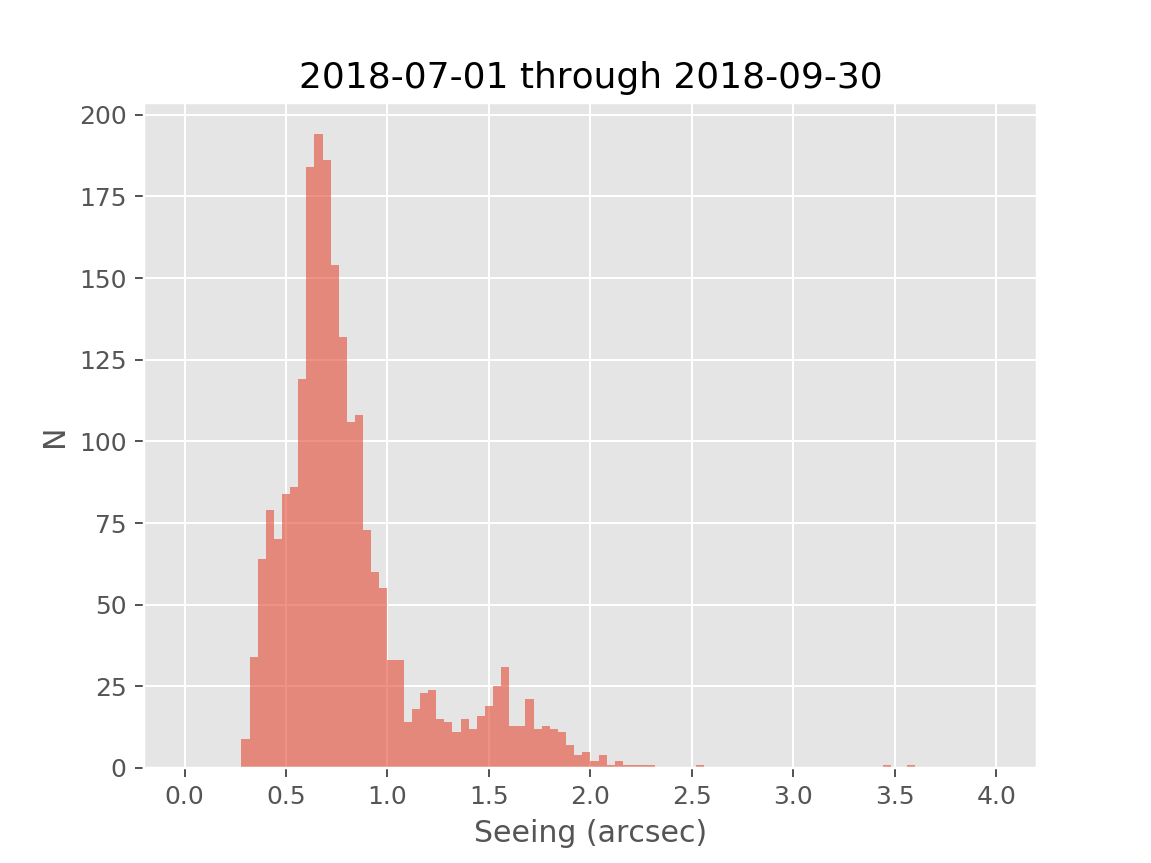

In [11]:
# make raw histogram of the zenith-corrected seeing column
fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
plt.title("2018-07-01 through 2018-09-30")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.show()

In [12]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = scipy.stats.lognorm.fit(fixed['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = scipy.stats.lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['seeing'])
fit_median = exp_mu + loc

0.5345821689365398 0.1860062306186112 0.5503990517722059


<IPython.core.display.Javascript object>


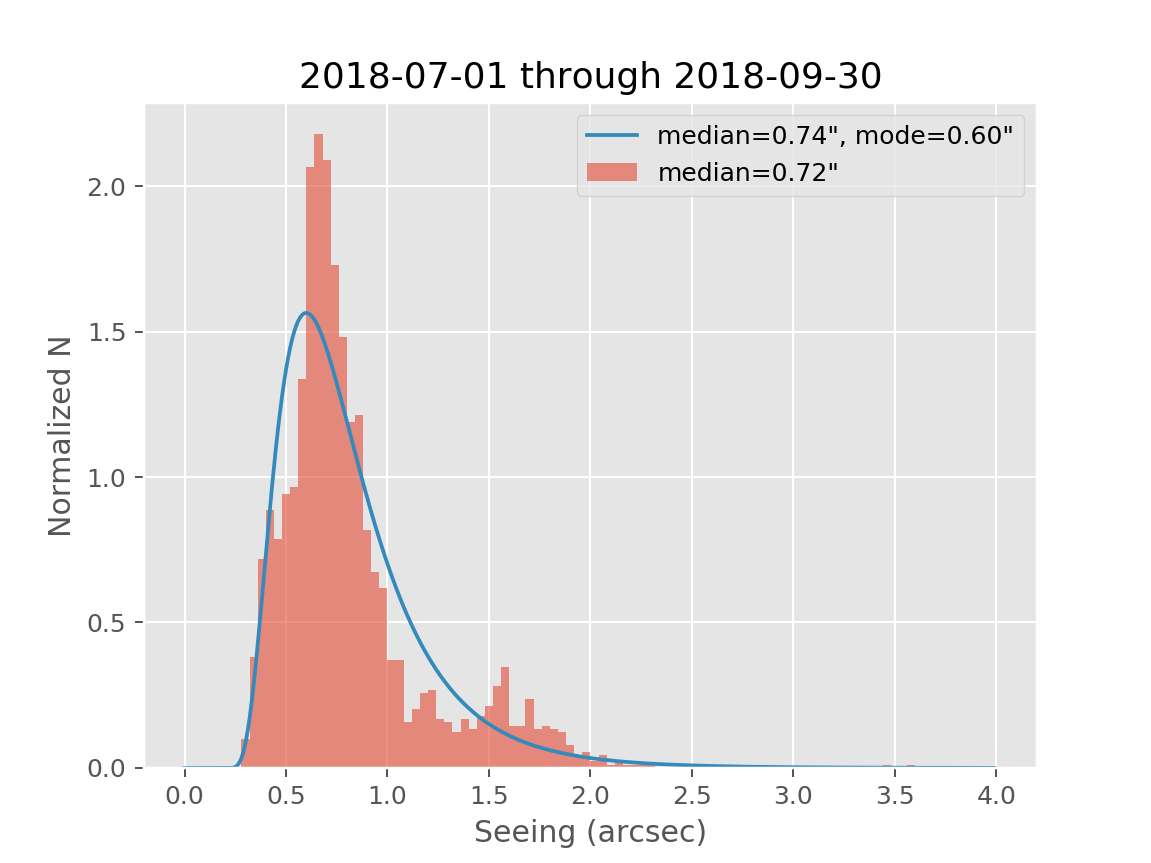

In [26]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
plt.hist(fixed['seeing'], density=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
logp = plt.plot(x, p, label="logp")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Normalized N")
plt.title("2018-07-01 through 2018-09-30")
plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
    median
)])
plt.savefig("2018q3_hist.png")
plt.show()

<IPython.core.display.Javascript object>


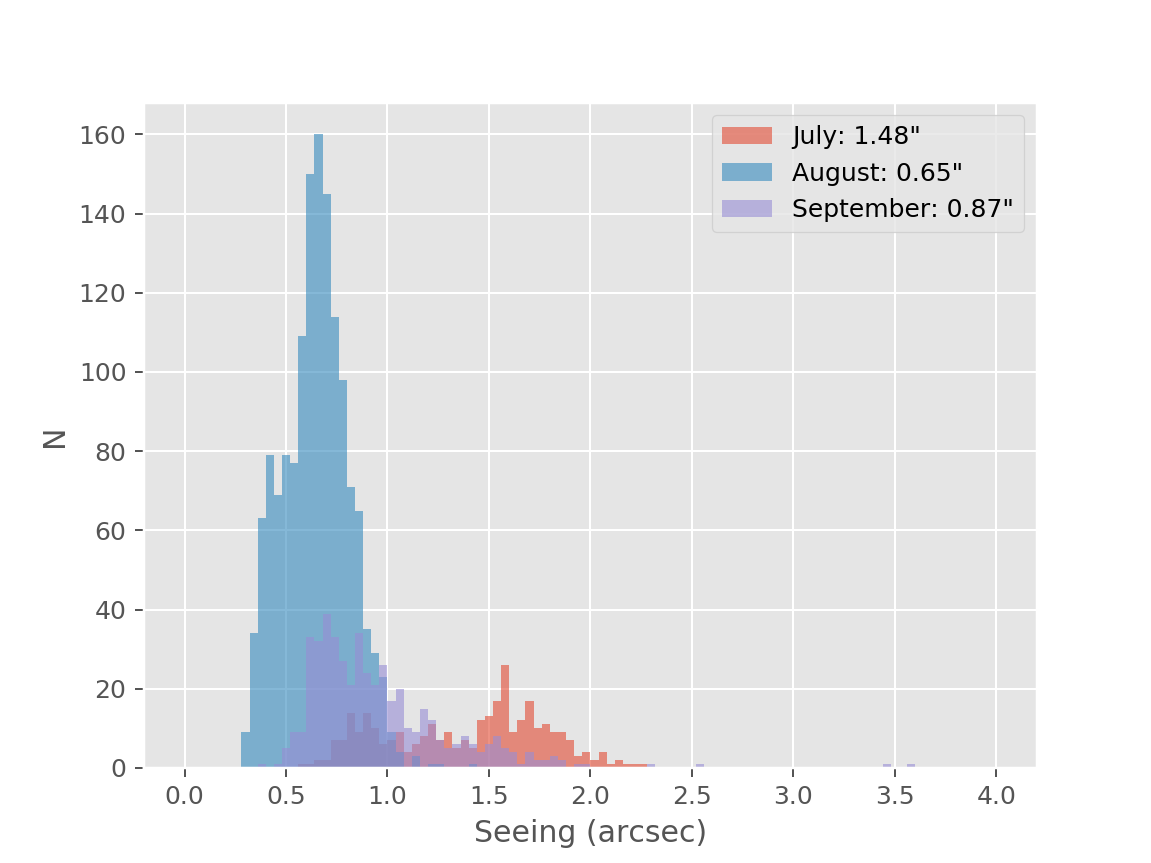

In [25]:
# panda time indexing makes it easy to group by month
months = {}
legends = []
months['July'] = fixed['2018-07']
months['August'] = fixed['2018-08']
months['September'] = fixed['2018-09']
for m in months:
    plt.hist(months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2018q3_monthly.png")
plt.show()

In [15]:
len(months['July']), len(months['August']), len(months['September'])

(322, 1428, 477)

In [16]:
# almost 2/3 the total amount of data was from MMIRS in august...
len(fixed)

2227

In [17]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
#first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
#second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

<IPython.core.display.Javascript object>


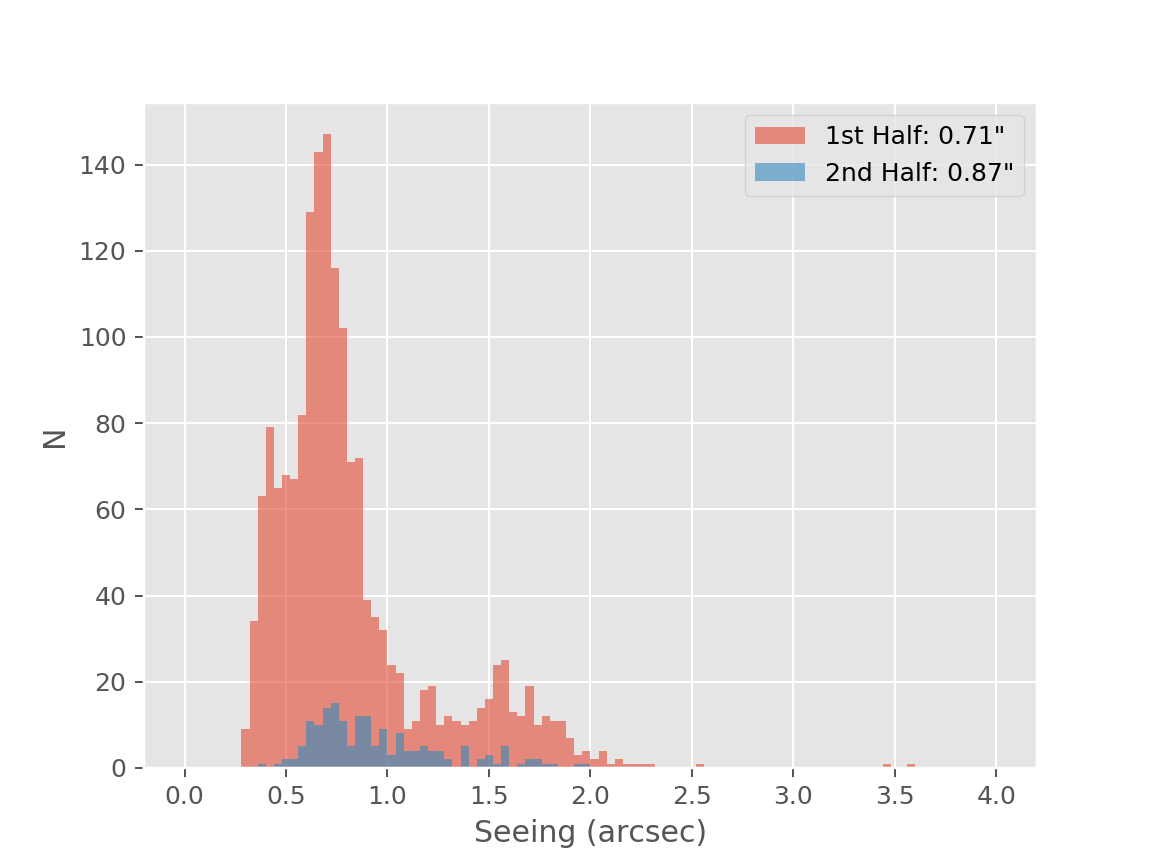

In [24]:
# plot the results and show that the seeing is better later in the night...
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2018q3_1st2nd.png")
plt.show()

<IPython.core.display.Javascript object>


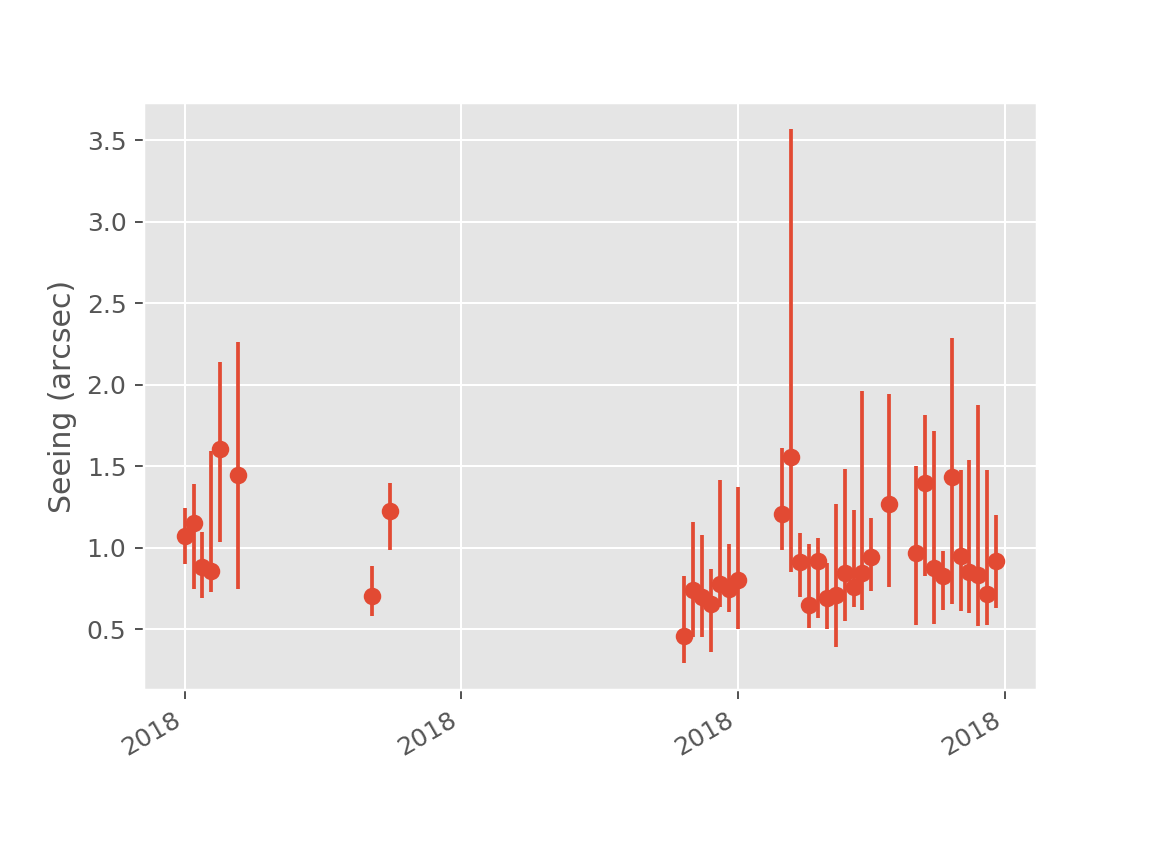

In [30]:
import matplotlib.dates as mdates

# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
#fixed = fixed["2018-06-30":"2018-10-01"]
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.seeing.resample('D').median()
daily['max'] = fixed.seeing.resample('D').max()
daily['min'] = fixed.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%"))
fig.autofmt_xdate()
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2018q3_nightly.pdf")
plt.show()

In [ ]:
daily.index

In [ ]:
n